<a href="https://colab.research.google.com/github/Kerriea-star/TensorFlow-Decision-Forests/blob/main/Learning_Decision_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Build, train and Evaluate a model with Decision Forests**

*Introduction*

In [33]:
pip install tensorflow_decision_forests

Installing TF-DF

In [34]:
pip install wurlitzer

Wurlitzer is needed to display the detailed training logs in Colabs (when using verbose=2 in the model)

In [35]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [36]:
from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setInfameHeight(0, true, {maxHeight: " + str(size) +"})"))

In [37]:
# check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v1.5.0


**Training a Random Forest Model**

In this section we train, evaluate, analyze and export a multi-class classification Random Forest trained on the Palmer's Penguins dataset

Let's assemble the dataset into a csv file (i.e. add the header), and load it:

In [38]:
# Download the Dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# load the dataset into a Pandas DataFrame
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


The dataset contains a mix of numerical (e.g bill_depth_mm), categorical(e.g. island) and missing features. TF-DF supports all these feature types natively (differently than NN based models), therefore there is no need for preprocessing in the form of one-hot encoding, normalization or extra is_[present feature.

Labels are a bit different:Keras metrics expect integers. The label (species) is stored as string, so let's convert it into an integer.

In [39]:
# Encode the categorical labels as integers
# Details:
# This is necessary if your classification label is represented as a
# string since Keras expects inter classification labels
# When using 'pd_dataframe_to_tf_dataset' (see below) this steo can be skipped.

# Name of the column.
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


Next split the dataset into training and testing

In [40]:
# Split the dataset into a training and testing dataset
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe into two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)
))

229 examples in training, 115 examples for testing.


And finally, convert the pandas dataframe (pd.DataFrame) into tensorflow datasets (tf.data.Datasets)

In [41]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

Recall that pd_dataframe_to_tf_dataset converts string labels to integers if necessary.

If you want to create the tf.data.Dataset yourself, there are a couple of things to remember


*   The learning algorithms work with a one-epoch dataset and without shuffling
*   The batch size does not impact the training algorithm, but a small value might slow down reading the dataset



**Train the model**

In [42]:
%set_cell_height 300

# Specify the model
model_1 = tfdf.keras.RandomForestModel(verbose=2)

# Train the model
model_1.fit(train_ds)

<IPython.core.display.Javascript object>

Use 2 thread(s) for training
Use /tmp/tmp_2b9a88w as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'island': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'bill_length_mm': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'bill_depth_mm': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'flipper_length_mm': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'body_mass_g': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'sex': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>, 'year': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>}
Label: Tensor("data_7:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'island': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>), 'bill_length_mm': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'bill_depth_mm': SemanticTensor(semantic=<Semantic.NUMERIC

[INFO 23-08-12 06:37:36.9400 UTC kernel.cc:773] Start Yggdrasil model training
[INFO 23-08-12 06:37:36.9401 UTC kernel.cc:774] Collect training examples
[INFO 23-08-12 06:37:36.9402 UTC kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-08-12 06:37:36.9406 UTC kernel.cc:393] Number of batches: 1
[INFO 23-08-12 06:37:36.9406 UTC kernel.cc:394] Number of examples: 229
[INFO 23-08-12 06:37:36.9408 UTC kernel.cc:794] Training dataset:
Number of records: 229
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	1: "bill_depth_mm" NUMERICAL num-nas:2 (0.873362%) mean:17.307 min:13

Model trained in 0:00:00.351432
Compiling model...
Model compiled.


Remarks

*   No input features are specified. Therefore, all the columns will be used as input features except for the label. The feature used by the model are shown in the training logs and the model_summary()
*   DFs consume natively numerical, categorical, categorical-set features and
missing values. Numerical features do not need to be normalized. Categorical string values do not need to be encoded in a dictionary.
*   No training hyper-parameters are specified. Therefore hyper-parameters will be used. Default hyper-parameters provide reasonable results in most situations.
*   Calling compile on the model before the fit is optional. Compile can be used to provide extra evaluation metrics.
*   Training algorithms do not need validation sets. If a validation set is provided, it will only be used to show metrics
*   Tweak the verbose argument to RandomForestModel to control the amount of displayed training logs. Set verbose=0 to hide most of the logs. Set verbose=2 to show all the logs





**Evaluate the model**

In [43]:
# Let's evaluate the model on the test dataset
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - accuracy: 0.9913

loss: 0.0000
accuracy: 0.9913


Remark: The test accuracy is close to the Out-of-bag accuracy shown in the training logs.



In [44]:
# Prepare the model for TensorFlow Serving
# Export the model to the SavedModel format later re-use e.g. TensorFlow Serving
model_1.save("/tmp/my_save_model")

In [45]:
# Prepare this model for TensorFlow Serving
# Export the model to the SavedModel format later re-use e.g. TensorFlow Serving
import os
import tempfile
import requests

MODEL_DIR = "ML/models/decision_forests"
version = "1"
export_path = os.path.join(MODEL_DIR, str(version))

# save the model
model_1.save(export_path, save_format="tf")
print("\nexport_path = {}".format(export_path))
!dir {export_path}


export_path = ML/models/decision_forests/1
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [46]:
!zip -r decision_forests.zip ML/models/decision_forests

updating: ML/models/decision_forests/ (stored 0%)
updating: ML/models/decision_forests/1/ (stored 0%)
updating: ML/models/decision_forests/1/keras_metadata.pb (deflated 79%)
updating: ML/models/decision_forests/1/assets/ (stored 0%)
updating: ML/models/decision_forests/1/saved_model.pb (deflated 86%)
updating: ML/models/decision_forests/1/fingerprint.pb (stored 0%)
updating: ML/models/decision_forests/1/variables/ (stored 0%)
updating: ML/models/decision_forests/1/variables/variables.index (deflated 46%)
updating: ML/models/decision_forests/1/variables/variables.data-00000-of-00001 (deflated 63%)
  adding: ML/models/decision_forests/1/assets/357e63858f724ad4done (stored 0%)
  adding: ML/models/decision_forests/1/assets/357e63858f724ad4data_spec.pb (deflated 16%)
  adding: ML/models/decision_forests/1/assets/357e63858f724ad4header.pb (deflated 30%)
  adding: ML/models/decision_forests/1/assets/357e63858f724ad4random_forest_header.pb (deflated 91%)
  adding: ML/models/decision_forests/1/

**Plot the model**

Plotting a decision tree and following the first branches helps learning about decision forests. In some cases, plotting a model can even be used for debugging.

Because of the difference in the way they are trained, some models are more interesting to plant than others. Because of the noise injected during training and the depth of the trees, plotting Random Forest is less informative than plotting a CART or the first tree of a Gradient Boosted Tree.

Never the less, let's plot the first tree of our Random Forest Model.

In [47]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

The root node in the left contains the first condition (bill_depth_mm >= 16.90), number of examples (239) and label distribution (the red-blue-green bar).

Examples that evaluates true to bill_depth_mm >= 16.90 are branched to the green path. The other ones are branched to the red path.

The deeper the node, the more pure they become i.e. the label distribution is biased toward a susbset of classes.

**Model Structure and feature importance**

The overall structure of the model is shown with .summary(). You will see:

*   **Type**: The learning algorithm used to train the model (RandomForest in our case).
*   **Task**: The problem solved by the model (Classification in our case).
*   **Input Features**: The input features of the model
*   **Variable Importance**: Different measures of the importance of each feature for the model
*   **Out-of-bag evaluation**: The out-of-bag evaluation of the model. This is a cheap and efficient alternative to cross-validation
*   **Number of {trees, nodes} and other metrics**: Statistics about the structure of the decision forests

**Remark**: The summary's content depends on the learning algorithm(e.g Out-of-bag is only available for Random Forest) and the hyper-parameters (e.g. the mean-decrease-in-accuracy variable importance can be disabled in the hyper-parameters).

In [48]:
%set_cell_height 300
model_1.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "flipper_length_mm"  0.451542 ################
    2.    "bill_length_mm"  0.436339 ##############
    3.     "bill_depth_mm"  0.302597 #####
    4.            "island"  0.301214 #####
    5.       "body_mass_g"  0.265289 ##
    6.               "sex"  0.232801 
    7.              "year"  0.231999 

Variable Importance: NUM_AS_ROOT:
    1. "flipper_length_mm" 159.000000 ################
    2.    "bill_length_mm" 86.000000 ########
    3.     "bi

In [49]:
# The information in summary are available programmatically using the model inspector
# The input features
model_1.make_inspector().features()

["bill_depth_mm" (1; #1),
 "bill_length_mm" (1; #2),
 "body_mass_g" (1; #3),
 "flipper_length_mm" (1; #4),
 "island" (4; #5),
 "sex" (4; #6),
 "year" (1; #7)]

In [50]:
# The feature importances
model_1.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("flipper_length_mm" (1; #4), 159.0),
  ("bill_length_mm" (1; #2), 86.0),
  ("bill_depth_mm" (1; #1), 40.0),
  ("island" (4; #5), 13.0),
  ("body_mass_g" (1; #3), 2.0)],
 'INV_MEAN_MIN_DEPTH': [("flipper_length_mm" (1; #4), 0.45154188849195864),
  ("bill_length_mm" (1; #2), 0.43633896689206025),
  ("bill_depth_mm" (1; #1), 0.3025965989147691),
  ("island" (4; #5), 0.3012143478668413),
  ("body_mass_g" (1; #3), 0.2652893766609197),
  ("sex" (4; #6), 0.23280097520584364),
  ("year" (1; #7), 0.23199923159643296)],
 'SUM_SCORE': [("bill_length_mm" (1; #2), 24871.004421988502),
  ("flipper_length_mm" (1; #4), 22637.932424640283),
  ("island" (4; #5), 8702.604792244732),
  ("bill_depth_mm" (1; #1), 8584.690925921313),
  ("body_mass_g" (1; #3), 2974.8327095713466),
  ("sex" (4; #6), 303.55172547884285),
  ("year" (1; #7), 66.41091401968151)],
 'NUM_NODES': [("bill_length_mm" (1; #2), 712.0),
  ("bill_depth_mm" (1; #1), 441.0),
  ("flipper_length_mm" (1; #4), 390.0),
  ("body_

The content of the summary and the inspector depends on the learning algorithm(tfdf.keras.RandomForestModel in class) and its hyper-parameters (e.g comput_oob_variable_importances=True will triger the computation of Out-of-bag variable importances for the Random Forest learner)

**Model Self Evaluation**

During training TFDF models can self evaluate even if no validation dataset is provided to the fit() method. The exact logic depends on the model. For example, Random Forest will use Out-of-bag evaluation while Gradient Boosted Trees will use internal train-validation.

**Note**: While this evaluation is computed during training, it is NOT computed on the training dataset and can be used as a low quality evaluation

The model self evaluation is available with the inspector's evaluation()

In [51]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=229, accuracy=0.9563318777292577, loss=0.1047447051966815, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

**Plotting the training logs**

The training logs show the quality of the model (e.g. accuracy evaluated on the out-of-bag or validation dataset) according to the number of trees in the model. These logs are helpful to study the balance between model size and model quality

The logs are available in multiple ways:

1.   Displayed in during training if fit() is wrapped in with sys_pipes().
2.   At the end of the model summary i.e. model.summary()
3.   Programmatically, using the model inspector i.e model.make_inspector().train_logs().
4.   Using TensorBoard

Let's try the options 2 and 3



In [52]:
%set_cell_height 150
model_1.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=79, accuracy=0.9746835443037974, loss=0.9124975083749506, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=227, accuracy=0.9515418502202643, loss=0.5637126631279874, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=229, accuracy=0.9519650655021834, loss=0.25147410443125856, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=229, accuracy=0.9563318777292577, loss=0.26274146577221336, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=229, accuracy=0.9519650655021834, loss=0.26867597055617376, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=229, accuracy=0.9432314410480349, loss=0.2675608186026848, rmse=N

Let's plot it

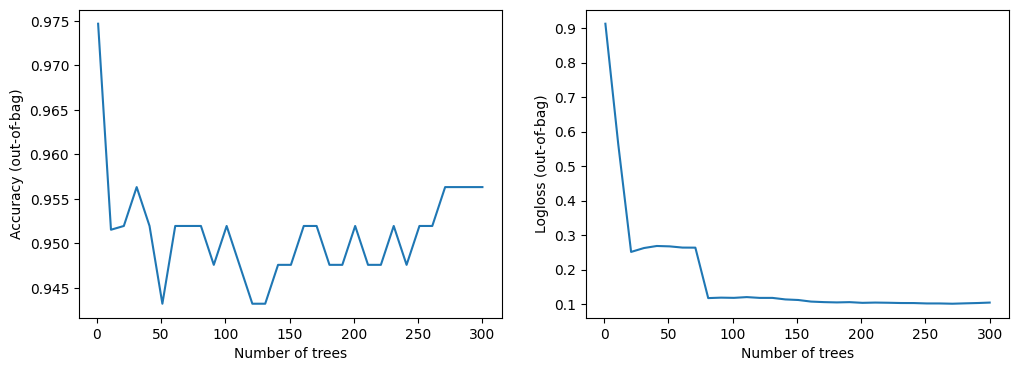

In [53]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

This dataset is small. You can see the model converging almost immediately.

Let's use TensorBoard

In [54]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
# export the meta-data to tensorboard
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")


In [56]:
# docs_infra: no_execute
# Start a tensorboard instance
%tensorboard --logdir "/tmp/tensorboard_logs"

Reusing TensorBoard on port 6006 (pid 1265), started 1:17:22 ago. (Use '!kill 1265' to kill it.)

<IPython.core.display.Javascript object>

**Re-trian the model with a different learning algorithm**

The learning algorithm is defined by the model class. For example, tfdf.keras.RandomForestModel() trains a Random Forest, while tfdf.keras.GradientBoostedTreesModel() trains a Gradient Boosted Decision Trees.

The learning algorithms are listed by calling tfdf.keras.get_all_models() or in the learner list.

In [57]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

The description of the learning algorithms and their hyper-parameters are also available in the API refrence and buitin help

In [58]:
# help works anywhere
help(tfdf.keras.RandomForestModel)

# ? only works in ipython or notebooks, it usually opens on a separate panel.
tfdf.keras.RandomForestModel?

Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(*args, **kwargs)
 |  
 |  Method resolution order:
 |      RandomForestModel
 |      tensorflow_decision_forests.keras.wrappers.RandomForestModel
 |      tensorflow_decision_forests.keras.core.CoreModel
 |      tensorflow_decision_forests.keras.core_inference.InferenceCoreModel
 |      keras.src.engine.training.Model
 |      keras.src.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.trackable.autotrackable.AutoTrackable
 |      tensorflow.python.trackable.base.Trackable
 |      keras.src.utils.version_utils.LayerVersionSelector
 |      keras.src.utils.version_utils.ModelVersionSelector
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {}
 |  
 |  -------------------------------------------------------------

**Using a subset of features**

The previous example did not specify the features, so all the columns were used as input feature(except for the label). The following example shows how to specify input features

In [59]:
feature_1 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_2 = tfdf.keras.FeatureUsage(name="island")

all_features = [feature_1, feature_2]

# Note: This model is only trained with two features. It will not be as good as
# the one trained on all features

model_2 = tfdf.keras.GradientBoostedTreesModel(
    features = all_features, exclude_non_specified_features=True
)
model_2.compile(metrics=["accuracy"])
model_2.fit(train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

Use /tmp/tmp3f5gqcsg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.350583. Found 229 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(115, shape=(), dtype=int32)
Validation dataset read in 0:00:00.263869. Found 115 examples.
Training model...
Model trained in 0:00:00.261240
Compiling model...
Model compiled.


1/1 [==============================] - 0s 152ms/step - loss: 0.0000e+00 - accuracy: 0.9826
{'loss': 0.0, 'accuracy': 0.9826086759567261}


**Note**: As expected, the accuracy is lower than previously

**TFDF** attaches a **semantics** to each feature. Thi semantics controls how the feature is used by the model. The following semantics are currently supported:

*   **Numerical**: Generally for quantities or counts with full ordering. For example, the age of a person, or the number of items in a bag. Can be a float or an integer. Missing values are represented with float(Nan) or with epmty sparse tensor.
*   **Categorical**: Generally for a type/class in finite set of possible values without ordering. For example, the color RED in the set {RED, BLUE, GREEN}. Can be a string or an integer. Missing values are represented as ""(empty string), value-2 or with an empty sparse tensor.
*   **Categorical-Set**: A set of categorical values. Great to represent tokenized text. Can be a string or an integer in a sparse tensor or a ragged tensor(recommended). The order/index of each item doesn't matter.

If not specified, the semantics is inferred from the representation type and shown in the training logs:

*   int, float(dense or sparse) - Numerical semantics
*   str(dense, sparse) - Categorical semantics
*   int, str(ragged) - Categorical-set semantics

In some cases, the inferred semantics is incorrect. For example: AN Enum stored as an integer is semantically categorical, but it will be detected as numerical. In this case, you should specify the semantic argument in the input. The education_num field of the Adult dataset is classical example.

This dataset doesn't contain such a feature. However, for the demonstration, we will make the model treat the year as a categorical feature.





In [60]:
%set_cell_height 300

feature_1 = tfdf.keras.FeatureUsage(name="year", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_3 = tfdf.keras.FeatureUsage(name="sex")
all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile( metrics=["accuracy"])

model_3.fit(train_ds, validation_data=test_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmpzy92t6uu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.293950. Found 229 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(115, shape=(), dtype=int32)
Validation dataset read in 0:00:00.256708. Found 115 examples.
Training model...
Model trained in 0:00:00.187758
Compiling model...
Model compiled.


Note that **year** is in the list of CATEGORICAL features (unlike the first run)

**Hyper-parameters**

Hyper-paramerters are parameters of the training algorithm that impact the quality of the final model. They are specified in the model class constructor. The list of hyper-parameters is visible with the *question mark* colab command (e.g. ?tfdf.keras.GradientBoostedTreesModel).

Alternatively, you can find them on the TensorFlow Decision Forest Github or the Yggdrasil Decision Forest documentation.

The default hyper-parameters of each algorithm matches approximately the initial publication paper. To ensure constancy, new features and their matching hyper-parameters are always disabled by default. That's why it is a good idea to tune your hyper-parameters.

In [61]:
# A classical but slightly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8
)
model_6.fit(train_ds)

Use /tmp/tmpcys6jr0g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.272828. Found 229 examples.
Training model...
Model trained in 0:00:00.379718
Compiling model...
Model compiled.


In [62]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees = 500,
    growing_strategy = "BEST_FIRST_GLOBAL",
    max_depth = 8,
    split_axis = "SPARSE_OBLIQUE",
    categorical_algorithm = "RANDOM",
)
model_7.fit(train_ds)

Use /tmp/tmpe97p3o1x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.219835. Found 229 examples.
Training model...
Model trained in 0:00:00.692204
Compiling model...
Model compiled.


As new training methods are published and implemented, combination of hyper-parameters can emerge as good or almost-always-better than the default parameters. To avoid changing the default hyper-parameter values these good combination are indexed and available as hyper-parameter templates.

For example, the benchmark_rank1 template is the best combination on our internal benchmarks. Those templates are versioned to allow training configuration stability e.g. benchmark_rank1@v1

In [63]:
# A good template of hyper-parameters.
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.fit(train_ds)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpfsaemeed as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.245389. Found 229 examples.
Training model...
Model trained in 0:00:00.476254
Compiling model...
Model compiled.


The available templates are available with **predefinefd_hyperparamerters**. Note that different learning algorithms have different templates, even if the name is similar.

In [64]:
# The hyper-parameters templates of the Gradient Boosted Tree model.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


**Feature Preprocessing**
Preprocessing features is sometimes necessary to consume signals with complex structures, to regularize the model or to apply transfer learning. Pre-processing can be done in one of three ways:

1.   Preprocessing on the Pandas dataframe. This solution is easy to implement and generally suitable for experimentation. However, the pre-processing logic will not be exported in the model by model.save()
2.   **Keras Preprocessing**: While more complex than the previous solution, Keras Preprocessing is packaged in the model.
3.   **TensorFlow Feature Columns**: This API is part of the TF Estimator library (!=Keras) and planned for deprication. This solution is interesting when using existing preprocessing code.

**Note**: Using TensorFlow Hub pre-trained embedding is often, a great way to consume text and image with TF-DF. For example, hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2").

In the next example, pre-process the body_mass_g feature into body_mass_kg = body_mass_g / 1000. The bill_length_mm is consumed without pre-processing. Note that such monotonic transformations have generally no impact on decision forest models.



In [67]:
%set_cell_height 300

body_mass_g = tf.keras.layers.Input(shape=(1, ), name="body_mass_g")
body_mass_kg = body_mass_g / 1000.0

bill_length_mm = tf.keras.layers.Input(shape=(1, ), name="bill_length_mm")

raw_inputs = {"body_mass_g": body_mass_g, "bill_length_mm": bill_length_mm}
processed_inputs = {"body_mass_kg": body_mass_kg, "bill_length_mm": bill_length_mm}


# "preprocessor" contains the preprocessing logic.
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

# "model_4" contains both the pre-processing logic and the decision forest.
model_4 = tfdf.keras.RandomForestModel(preprocessing=preprocessor)
model_4.fit(train_ds)

model_4.summary()

<IPython.core.display.Javascript object>

Use /tmp/tmp1a8ihak_ as temporary training directory
Reading training dataset...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['island', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Training dataset read in 0:00:00.363243. Found 229 examples.
Training model...
Model trained in 0:00:00.084802
Compiling model...
Model compiled.


Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          {'body_mass_kg': (None,   0         
                              1),                                
                              'bill_length_mm': (Non             
                             e, 1)}                              
                                                                 
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	bill_length_mm
	body_mass_kg

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "bill_length_mm"  1.000000 ################
    2.   "body_mass_kg"  0.428435 

Variable Importance: NUM_AS_ROOT:
    1. "bill_length_mm" 300.000000 

Variable Importance: N

The following example re-implements the same logic using TensorFlow Feature Columns.

In [68]:
def g_to_kg(x):
  return x / 1000

feature_columns = [
    tf.feature_column.numeric_column("body_mass_g", normalizer_fn=g_to_kg),
    tf.feature_column.numeric_column("bill_length_mm"),
]

preprocessing = tf.keras.layers.DenseFeatures(feature_columns)

model_5 = tfdf.keras.RandomForestModel(preprocessing=preprocessing)
model_5.fit(train_ds)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Use /tmp/tmp5vng5kjj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.248525. Found 229 examples.
Training model...
Model trained in 0:00:00.088429
Compiling model...
Model compiled.


**Training a regression model**

The previous example trains a classifation model (TF-DF does not differente between binary classification and multi-class classification). In the next example, train a regression model on the Abalone dataset. The objective of the dataset is to predict the number of shell's rings of an abalone.

**Note**: The csv file is assembled by appending UCI's header and data files. No preprocessing was applied.

In [69]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/abalone_raw.csv -O /tmp/abalone.csv

dataset_df = pd.read_csv("/tmp/abalone.csv")
print(dataset_df.head(3))

  Type  LongestShell  Diameter  Height  WholeWeight  ShuckedWeight  \
0    M         0.455     0.365   0.095       0.5140         0.2245   
1    M         0.350     0.265   0.090       0.2255         0.0995   
2    F         0.530     0.420   0.135       0.6770         0.2565   

   VisceraWeight  ShellWeight  Rings  
0         0.1010         0.15     15  
1         0.0485         0.07      7  
2         0.1415         0.21      9  


In [71]:
# split the dataset into a training and testing dataset
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd))
)

# Name of the label column
label = "Rings"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)


2922 examples in training, 1255 examples for testing.


In [72]:
%set_cell_height 300

# Configure the model
model_7 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Train the model
model_7.fit(train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmp5f64m1aq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.290835. Found 2922 examples.
Training model...
Model trained in 0:00:02.892739
Compiling model...
Model compiled.


In [73]:
# Evaluate the model on the test dataset
model_7.compile(metrics=["mse"])
evaluation = model_7.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

2/2 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - mse: 4.4173
{'loss': 0.0, 'mse': 4.417268753051758}

MSE: 4.417268753051758
RMSE: 2.101729942940281
